In [8]:
!pip install fslpy

You should consider upgrading via the '/home/tara/Programming/env/bin/python -m pip install --upgrade pip' command.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from nilearn import datasets
import nilearn
from nilearn import masking
from nilearn import plotting
from nilearn import image
import os
import fsl.wrappers as fsl
import pandas as pd
#os.environ['FSLDIR'] = '/usr/local/fsl'
#os.environ['FSLOUTPUTTYPE'] = 'NIFTI_GZ'
from IPython.display import clear_output

In [125]:
#RG = input('Enter research group (eg. AD_SDB+): ')

Enter research group (eg. AD_SDB+): LMCI_SDB-


In [2]:
#schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=17, resolution_mm=2, data_dir=None, base_url=None, resume=True, verbose=1)

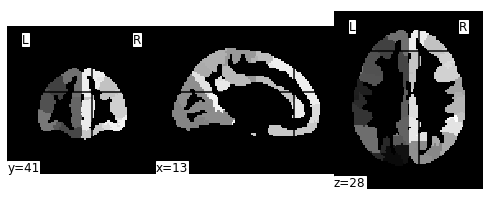

In [3]:
#plotting.plot_img(schaefer.maps, cmap = plt.cm.gray)

In [4]:
#img = image.load_img('atl-Buckner17_space-MNI_dseg.nii')

In [6]:
#fsl.fslmaths('atl-Buckner17_space-MNI_dseg.nii').thr(149).uthr(149.5).run('test.nii.gz')

{}

## Step 2: creating masks

In [20]:
regions = pd.read_csv('BN_Atlas_246_LUT_text.csv')
regions

,Value,ROI_Name
0,211,mAmyg_L
1,212,mAmyg_R
2,213,lAmyg_L
3,214,lAmyg_R
4,215,rHipp_L
5,216,rHipp_R
6,217,cHipp_L
7,218,cHipp_R
8,219,vCa_L
9,220,vCa_R


In [21]:
for region in regions['ROI_Name']:
    #if region.find('Default') != -1:
    parcel = regions[regions['ROI_Name'] == region]
    #print(int(parcel['Value']), ' *** ', region)
    name = 'Brainnetome_masks/'+region+'.nii.gz'
    parcel = int(parcel['Value'])
    fsl.fslmaths('BN_Atlas_246_2mm.nii').thr(parcel).uthr(parcel+0.5).run(name)

## Step 3: applying Vermis mask

In [126]:
table = pd.read_csv('Groups/'+RG+'.csv').drop(columns='Unnamed: 0')

In [127]:
table_ind = table.set_index('costume_index')

In [128]:
table_ind.head()

,Subject ID,Study Date,Sex,Weight,Age,SDB,MMSCORE,CHANGE,Image ID,SIENA,PET_Image_ID
costume_index,,,,,,,,,,,
LMCI1aN,4015,2011-04-05,F,52.2,73.7,0,NaN,0,226174,0.000000,232197.0
LMCI1bN,4015,2012-04-11,F,52.5,74.7,0,NaN,0,296930,-4.194045,NaN
LMCI1cN,4015,2013-04-19,F,49.8,75.7,0,NaN,0,368101,-4.604850,371779.0
LMCI2aN,4035,2011-07-28,F,59.0,72.8,0,NaN,0,247488,0.000000,257595.0
LMCI2bN,4035,2012-10-09,F,59.3,74.0,0,NaN,0,339412,-3.592881,NaN


In [129]:
subs = os.listdir(RG)
masks = os.listdir('masks')
Vermis_mask = image.load_img('Vermis_resize.nii')
LEN1 = len(subs)
LEN2 = len(masks)
cnt = 0
for i, sub in enumerate(subs):
    drc = RG+'/'+sub
    tps = os.listdir(drc)    
    for tp in tps:
        if tp.find('w')==0:
            #print(tp)
            ind = tp[1:len(tp)-4]
            source = drc+'/'+tp
            img = image.load_img(source)
            fsl.fslmaths(img).mas(Vermis_mask).run('Vmask_img.nii.gz')
            Vmask_img = image.load_img('Vmask_img.nii.gz')
            Vermis_meanValue = fsl.fslstats(Vmask_img).__getattr__('n').__getattr__('M').run()
            #print(Vermis_meanVal9ue)
            for j, mask in enumerate(masks):
                #print(mask)
                mask_name = mask.split('.')[0]
                mask_name = mask_name.split('_')
                col = mask_name[1]+'_'+mask_name[2]+'_'+mask_name[3]+'_'+mask_name[4]
                if col not in table_ind:
                    table_ind.insert(9, col, np.nan)
                mask_dir = 'masks/'+mask
                current_mask = image.load_img(mask_dir)
                #current_mask = image.resample_to_img(source_img=current_mask, target_img=img)
                fsl.fslmaths(img).mas(current_mask).run('mask_img.nii.gz')
                mask_img = image.load_img('mask_img.nii.gz')
                meanValue = fsl.fslstats(mask_img).__getattr__('n').__getattr__('M').run()
                prop = meanValue/Vermis_meanValue
                table_ind.loc[ind, col] = prop
                #print(tp, ' ', col, ' uptake: ', prop)
                
                clear_output(wait=True)
                cnt = i*LEN2+j
                prc = (cnt*100)/(LEN1*LEN2-1)
                print("%.2f"%prc,"%")

100.00 %


In [130]:
output = table_ind.reset_index()
output.head()

,costume_index,Subject ID,Study Date,Sex,Weight,Age,SDB,MMSCORE,CHANGE,Image ID,...,LH_DefaultA_pCunPCC_3,LH_DefaultA_pCunPCC_2,LH_DefaultA_pCunPCC_1,RH_DefaultC_Rsp_2,RH_DefaultC_Rsp_1,RH_DefaultC_PHC_2,RH_DefaultC_PHC_1,RH_DefaultC_IPL_1,SIENA,PET_Image_ID
0,LMCI1aN,4015,2011-04-05,F,52.2,73.7,0,NaN,0,226174,...,1.253461,1.457896,1.402922,1.265132,0.947330,0.915774,0.675224,1.057517,0.000000,232197.0
1,LMCI1bN,4015,2012-04-11,F,52.5,74.7,0,NaN,0,296930,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.194045,NaN
2,LMCI1cN,4015,2013-04-19,F,49.8,75.7,0,NaN,0,368101,...,1.106282,1.308864,1.264063,1.109418,0.845469,0.855296,0.650909,0.941549,-4.604850,371779.0
3,LMCI2aN,4035,2011-07-28,F,59.0,72.8,0,NaN,0,247488,...,1.190651,1.333613,1.317894,1.130303,0.842520,0.949627,0.811867,0.947487,0.000000,257595.0
4,LMCI2bN,4035,2012-10-09,F,59.3,74.0,0,NaN,0,339412,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.592881,NaN


In [131]:
out = 'outputs/'+RG+'.csv'
output.to_csv(out)